### GAIA optimiation DBSCAN with MCMC scheme

1. using a simple ABC scheme
2. ...

In [ ]:

using PyCall
using Distributions
using Statistics , StatsBase

using Distances
using Random

push!(LOAD_PATH,"/home/stephane/Science/cluster/GAIA/master/src")
using GaiaClustering

import PyPlot


## directory
rootdir = "/home/stephane/Science/cluster/GAIA"
wdir    = "/home/stephane/Science/cluster/GAIA/products"

cd(wdir)


#### mutable MC and model

mutable struct mc
    eps::Array{Float64}
    mne::Array{Int32}
    mcl::Array{Int32}
    qc::Array{Float64}
end

mutable struct model
    eps::Float64
    min_nei::Int
    min_cl::Int
end

struct abc
    minQ::Float64
    epsmean::Float64
    epsdisp::Float64
    min_nei::Int
    min_cl::Int
    nburnout::Int
    niter::Int
end

In [ ]:
### generate eps, min_neightbor and min_cluster
###
### aeps,amin_nghb, amin_cluster are the parameter of the prior density for the DBSCAN parameters

function theta(a1eps, a2eps, amin_nghb, amin_cluster)
    eps = TruncatedNormal(a1eps, a2eps,0.1,1000.)
    minneighbor = Poisson(amin_nghb)
    mincluster = Poisson(amin_cluster)
    
    e = rand(eps)          ; pe = pdf(eps,e)
    n = rand(minneighbor)  ; pn = pdf(minneighbor, n)
    c = rand(mincluster)   ; pc = pdf(mincluster, c)
    
    ptotal = pe*pn*pc
    params = model(e, n, c)
    return(params, ptotal)
end


## iterate with random walk and yield the probability
##
function thetaiter(θi::model , a1eps, a2eps, amin_nghb, amin_cluster)
    let   
        eps         = TruncatedNormal(a1eps, a2eps,0.1,1000.)
        minneighbor = Poisson(amin_nghb)
        mincluster  = Poisson(amin_cluster)
    
        eps_rw = TruncatedNormal(θi.eps,0.5, 0.1, 1000.)
        new_e = 0.
        new_mn = 0
        new_mcl = 0
        
        iternotfound =true
        while iternotfound
            new_e = rand(eps_rw)
        
            ap = rand()
            if ap > 0.5
                new_mn = θi.min_nei + 1
            else
                new_mn = θi.min_nei -1 
            end
            ap = rand()
            if ap > 0.5
                new_mcl = θi.min_cl + 1
            else
                new_mcl = θi.min_cl -1 
            end        
        
            if new_e > 0 && new_mn > 0 && new_mcl > 0
                iternotfound = false
            end
        end
    
        pe = pdf(eps,new_e)
        pn = pdf(minneighbor, new_mn)
        pc = pdf(mincluster, new_mcl)
        ptotal = pe * pn * pc
    
        params = model(new_e, new_mn, new_mcl)
        return(params, ptotal)
    end
end   

In [ ]:
## compute the dbscan clusters, the metric and the Metropolis acceptance

function find_clusters(df::GaiaClustering.Df, dfcart::GaiaClustering.Df , m::model)
    let 
        labels = clusters(df.data , m.eps , 20, m.min_nei, m.min_cl)
        if length(labels) == 0
            return(0)
        end
        
    ### metrics of the clusters
        q2d = metric(dfcart, labels, "spatial2d" , 2.0 , 20.0, 20 )
        qv = metric(dfcart, labels, "velocity" , 3.0 , 30.0, 20 )
        qp, qa = metric(dfcart, labels, "HRD" )
    
        nlab = []
        for ilab in labels
            push!(nlab,length(ilab))
        end
    
    
    #### metric for number of stars in the cluster
        qn = []
        for nl in nlab
            push!(qn,log10(nl))
        end
    
        qc = 0.
        for i in 1:length(nlab)
            k1 = q2d[i][1]
            k2 = qv[i][1]
            k3 = qa[i][1]
            k4 = qn[i]
            qq = (2 * k1 + 3 * k2 + k3 ) / 6.0
            qc = max(qq,qc)
        end
        return(qc)
    end
end

In [ ]:
function getdata(filevot)
    voname = filevot

    data       = read_votable(voname)
    df         = filter_data(data)
    dfcart     = add_cartesian(df)
    blck       = [[1,2,3],[4,5], [6,7,8]]
    wghtblck   = [4.0,5.0,1.0]
    norm       = "identity"

    dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false) 
    return(dfcartnorm , dfcart)
end

In [ ]:
## ABC MCMC (following Weyan et al. 2013)
## first simple scheme for testing
##
function abc_mcmc(df::GaiaClustering.Df, dfcart::GaiaClustering.Df, params::abc)
    let 
        mci = mc(zeros(Float64,0),zeros(Int32,0),zeros(Int32,0) , zeros(Float64,0))
        
        initial = true
        th = []
        mi = model(0.0,0,0)
        micurrent = model(0.0,0,0)
        probi = 0.
        probcurrent = 0.
    
        minimumQ = params.minQ
        niter = params.niter
        nburn = params.nburnout
    
        
        while initial
            mi, probi = theta(params.epsmean,params.epsdisp,params.min_nei,params.min_cl)
            qres = find_clusters(df, dfcart, mi)
        
            if qres > minimumQ
                println("## MCMC: init done ...")
                initial = false
                push!(mci.eps, mi.eps)
                push!(mci.mne, mi.min_nei)
                push!(mci.mcl, mi.min_cl)
                push!(mci.qc,  qres)
            end
        end
    
        nchain = 1
        loopAgain = true
        burndone = false
                    
        while loopAgain
            micurrent, probcurrent = thetaiter(mi , params.epsmean,params.epsdisp,params.min_nei,params.min_cl)
            qres = find_clusters(df, dfcart, micurrent)
        
            if qres > minimumQ
            ### Metropolis-Hasting
                α = probcurrent / probi
                if α > rand() 
                    nchain += 1
                    if (nchain%500 == 0) println("### chain:",nchain) end
                    if nchain > nburn && !burndone println("### burnout done...") ; burndone = true end
                    if nchain > nburn+niter loopAgain = false end
                    if burndone
                        mi = micurrent
                        push!(mci.eps, mi.eps)
                        push!(mci.mne, mi.min_nei)
                        push!(mci.mcl, mi.min_cl)
                        push!(mci.qc , qres)
                    end
                end
            end
        end
        return(mci)
    end
end

## Main ...
## Votable test.vot read
## Filtering done ...
## Stars selected: 12531
## Cartesian transformation done ...
## Normalization identity done...
### [1pc,1pc,1pc,1km/s,1km/s,1mag,1mag] equivalent to [0.398015, 0.398015, 0.398015, 0.497519, 0.497519, 0.0995037, 0.0995037, 0.0995037]
## MCMC : Q minimum  = 2.5
## MCMC : iterations = 100
## MCMC: init done ...
### burnout done...
## MCMC done.


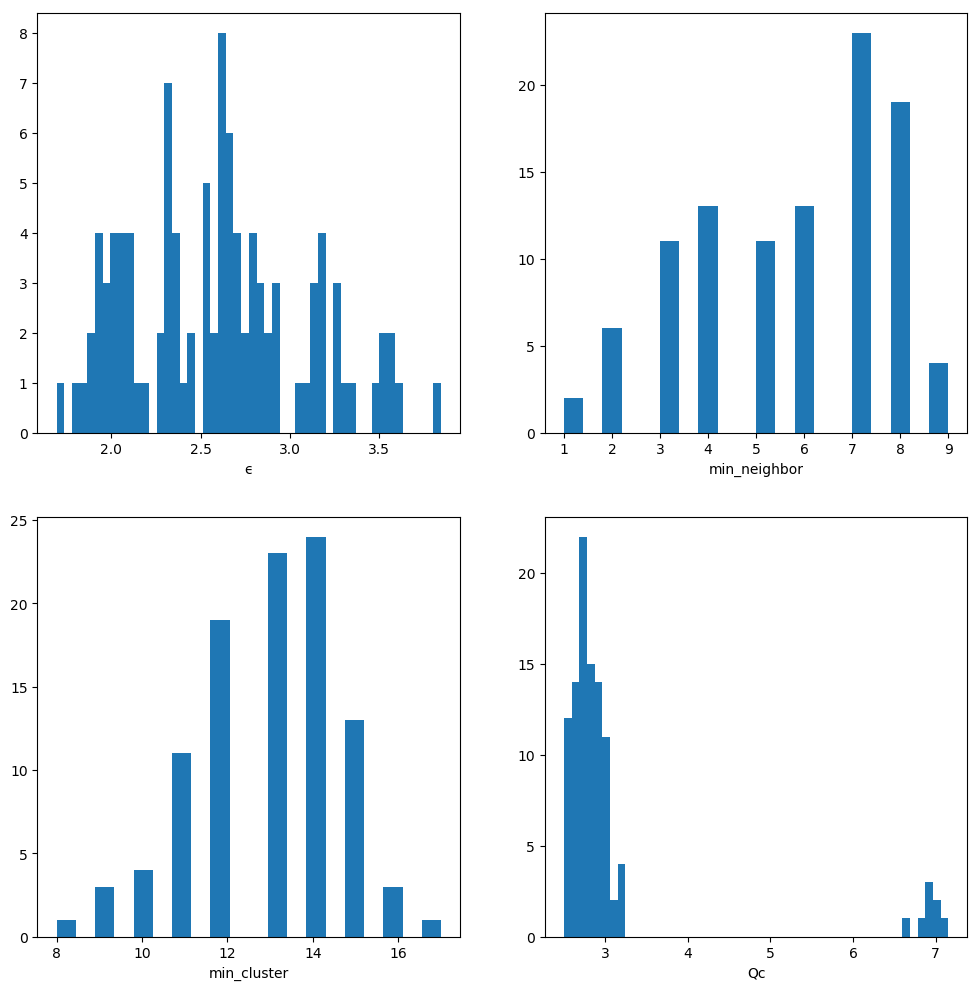

## Stats:
ϵ : 2.594067657520302
min_nei  : 5.696078431372549
min_clus  : 12.931372549019608
Qc  : 3.120534240034077


In [7]:
### main loop

function main(params::abc)
    Random.seed!(1237)
    println("## Main ...")
    
    ## Get the cluster data..
    dfnorm , dfcart = getdata("test.vot")
    
    ## run the mcmc for the dbscan parameters

    println("## MCMC : Q minimum  = ", params.minQ)
    println("## MCMC : iterations = ", params.niter)
    mc = abc_mcmc(dfnorm, dfcart, params)
    
    println("## MCMC done.")
    
    ## plots ################################
    
    PyPlot.plt[:figure](figsize=(12.0,12.0))

    
    nbins = 50
    PyPlot.plt[:subplot](2, 2, 1  )
    h = PyPlot.plt[:hist](mc.eps,nbins)
    PyPlot.plt[:xlabel]("ϵ")
    
    nbins = 20
    PyPlot.plt[:subplot](2, 2, 2 )
    h = PyPlot.plt[:hist](mc.mne,nbins)
    PyPlot.plt[:xlabel]("min_neighbor")  
    
    nbins = 20
    PyPlot.plt[:subplot](2, 2, 3 )
    h = PyPlot.plt[:hist](mc.mcl,nbins)
    PyPlot.plt[:xlabel]("min_cluster") 
    
    nbins = 50
    PyPlot.plt[:subplot](2, 2, 4 )
    h = PyPlot.plt[:hist](mc.qc,nbins)
    PyPlot.plt[:xlabel]("Qc") 
    PyPlot.plt[:savefig]("dbscan-abc.png")
    PyPlot.plt[:show]()
    
    ## Stats
    println("## Stats:")
    println("ϵ : ",mean(mc.eps))
    println("min_nei  : ",mean(mc.mne))
    println("min_clus  : ",mean(mc.mcl))
    println("Qc  : ",mean(mc.qc)) 
    
    
    
end

### main 
minQ    = 2.5
epsmean = 1.0
epsdisp = 1.5
min_nei = 5
min_cl  = 10
nburnout = 100
niter    = 100
pinit = abc(minQ, epsmean,epsdisp,min_nei, min_cl, nburnout , niter)
main(pinit)